In [48]:
from sippy import *
import numpy as np
import pandas as pd
from sippy import functionset as fset
from sippy import functionsetSIM as fsetSIM
from matplotlib import pyplot as plt

In [49]:
#load spteptest data from a TSV file
file = 'upstream_june_extracted.txt'
step_test_data = pd.read_table(file,header=[0, 1,2],index_col=[0], parse_dates=[0])
step_test_data.head()

Time,KOPC_OP,KOPC_SP,PIC100_OP,PIC100X_SP,TIC100_OP,TIC100_SP,GAS.PV,HPCPOWER.PV,WELL1.OP,WELL2.OP,WELL3.OP
,KOPC Output,KOPC Set Point,PIC100 Output,PIC100X Set Point,TIC100 Output,TIC100 Set Point,b,HP Comp. Power,Well 1 Valve %,Well 2 Valve %,Well 3 Valve %
,%,kPa,%,kPa,%,C,x,kW,%,%,%
2016-06-24 04:00:00,79.6364,2686.11,45.4004,2824.85,18.1808,23.8889,145.640,2986.44,71.0091,79.852,81.0388
2016-06-24 04:01:00,79.9249,2686.11,45.4011,2824.85,18.1672,23.8889,145.748,2985.65,71.0091,79.852,81.0388
2016-06-24 04:02:00,79.6582,2686.11,45.4023,2824.85,18.1581,23.8889,145.488,2986.79,71.0091,79.852,81.0388
2016-06-24 04:03:00,79.6933,2686.11,45.4056,2824.85,18.1508,23.8889,145.537,2984.94,71.0091,79.852,81.0388
2016-06-24 04:04:00,79.7847,2686.11,45.4096,2824.85,18.1377,23.8889,145.551,2983.96,71.0091,79.852,81.0388


In [50]:
#slice data for model identification case
start = '2016-07-01 04:00:00'
end = '2016-07-04 03:59:00'
step_test = step_test_data.loc[start:end]
Time = step_test.index

#Drop mutilevel index
step_test.columns = [col[0] for col in step_test.columns]
step_test.head()

,KOPC_OP,KOPC_SP,PIC100_OP,PIC100X_SP,TIC100_OP,TIC100_SP,GAS.PV,HPCPOWER.PV,WELL1.OP,WELL2.OP,WELL3.OP
2016-07-01 04:00:00,69.9488,2730.13,45.0977,2821.55,18.8697,21.7889,143.202,3019.89,79.5119,70.3849,78.9292
2016-07-01 04:01:00,69.9910,2730.13,45.0956,2821.55,18.8879,21.7889,143.460,3020.84,79.5119,70.3849,78.9292
2016-07-01 04:02:00,70.1902,2730.13,45.0961,2821.55,18.9026,21.7889,143.491,3019.61,79.5119,70.3849,78.9292
2016-07-01 04:03:00,69.9426,2730.13,45.0984,2821.55,18.9314,21.7889,143.357,3020.91,79.5119,70.3849,78.9292
2016-07-01 04:04:00,69.7443,2730.13,45.1050,2821.55,18.9332,21.7889,143.493,3019.42,79.5119,70.3849,78.9292


In [63]:
#select Inputs and Outputs for the model identification case
inputs = ['KOPC_SP', 'PIC100X_SP', 'TIC100_SP', 'WELL1.OP', 'WELL2.OP', 'WELL3.OP']
outputs = ['GAS.PV', 'HPCPOWER.PV', 'KOPC_OP', 'PIC100_OP', 'TIC100_OP']

In [64]:
#Convert dataframe to numpy arry.
u = step_test[inputs].to_numpy().T
y = step_test[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (5, 4320)
Input shape: (6, 4320)


In [68]:
#Identify model
method='CVA'
sys_id = system_identification(
    y, 
    u, 
    method,
    SS_fixed_order=25,
    SS_f=120,
#     SS_p=120,
    SS_D_required=False,
    SS_A_stability=False)

#save model parameters A, B, C,D and X0 as npz file
np.savez('model.npz', A=sys_id.A, B=sys_id.B, C=sys_id.C, D=sys_id.D, X0=sys_id.x0)

In [83]:
def plot_comparison(step_test_data, inputs, outputs, start_time, end_time, plt_input=False):
    """
    Plot the predicted and true output-signals.
    
    :param step_test_data: dataframe bject of loaded data.
    :param inputs: Input vectors of the model.
    :param outputs: Output vectors of the model.
    :param start_time: Starting time of prediction data.
    :param end_time: Ending time of prediction data.
    :param plt_output: Boolean whether to Input vectors.
    """
    
    val_data = step_test_data.loc[start_time:end_time]
    val_data.columns = [col[0] for col in val_data.columns]
    
    Time = val_data.index
    u = val_data[inputs].to_numpy().T
    y = val_data[outputs].to_numpy().T


    # Use the model to predict the output-signals.
    mdl = np.load('model.npz')
    
    # The output of the model
    xid, yid = fsetSIM.SS_lsim_process_form(mdl['A'], mdl['B'], mdl['C'], mdl['D'], u, mdl['X0'])
    
    # Make the plotting-canvas bigger.
    plt.rcParams['figure.figsize'] = [25, 5]
    # For each output-signal.
    for idx in range(0,len(outputs)):
        plt.figure(idx)
        plt.plot(Time, y[idx])
        plt.plot(Time, yid[idx])
        plt.ylabel(outputs[idx])
        plt.grid()
        plt.ylim(np.amin(y[idx])*.99, np.amax(y[idx])*1.01)
        plt.xlabel("Time")
        plt.title('output_'+ str(idx+1))
        plt.legend(['measurment', 'prediction'])
        
    if plt_input == True:
        for idx in range(len(outputs), len(outputs) + len(inputs)):
            plt.figure(idx)
            plt.plot(Time, u[idx-len(outputs)])
            plt.ylabel(inputs[idx-len(outputs)])
            plt.grid()
            plt.xlabel("Time")
            plt.title('input_'+ str(idx-len(outputs)+1))
    plt.show()

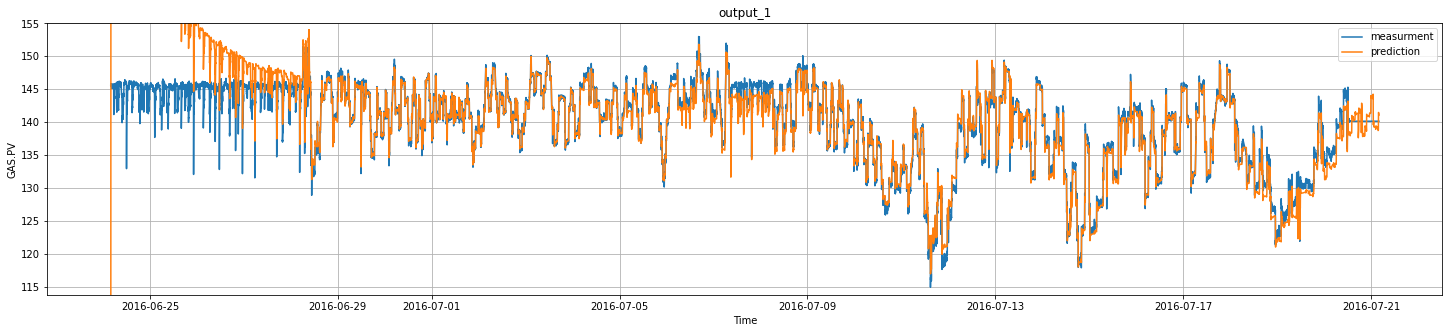

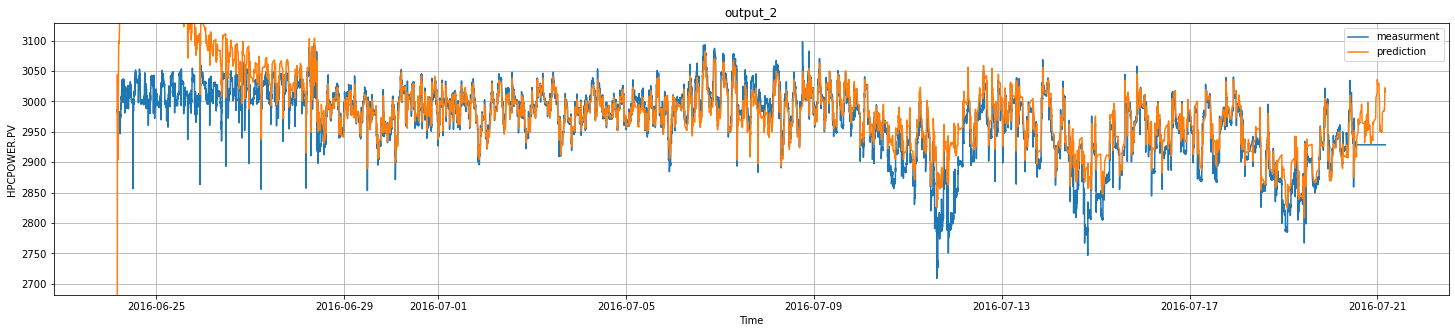

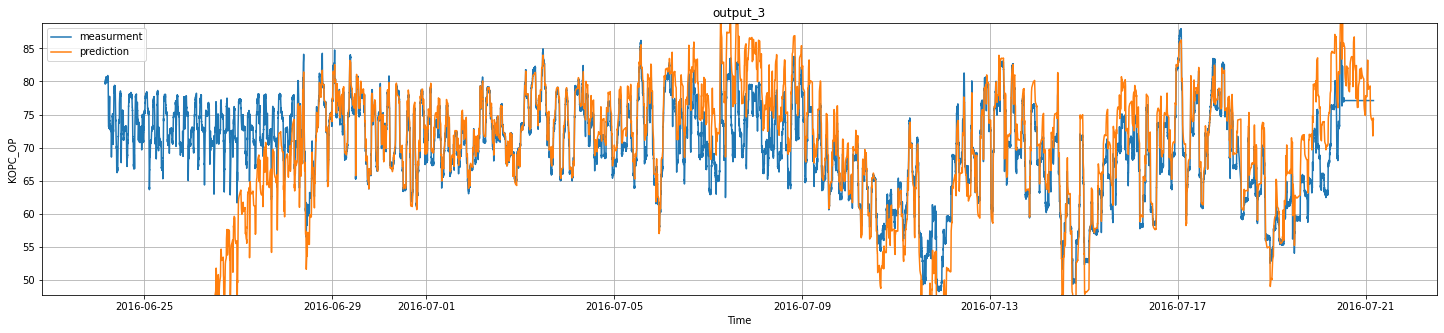

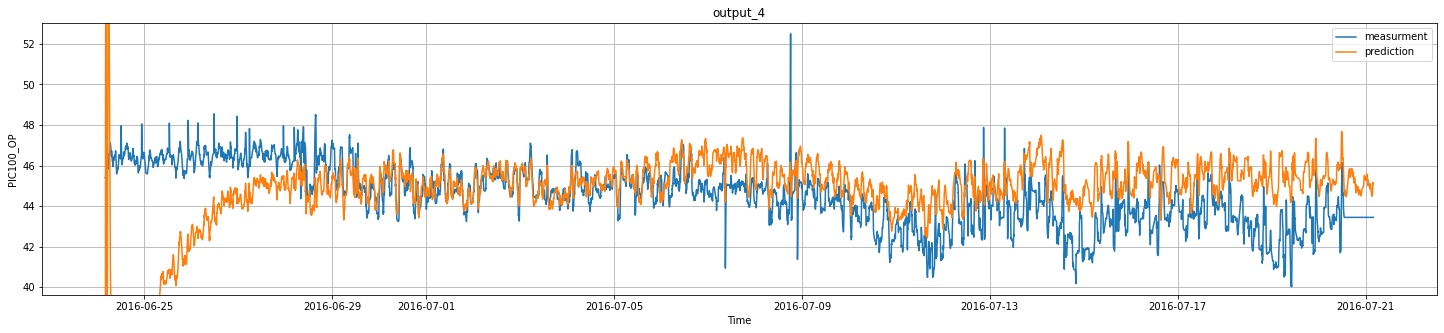

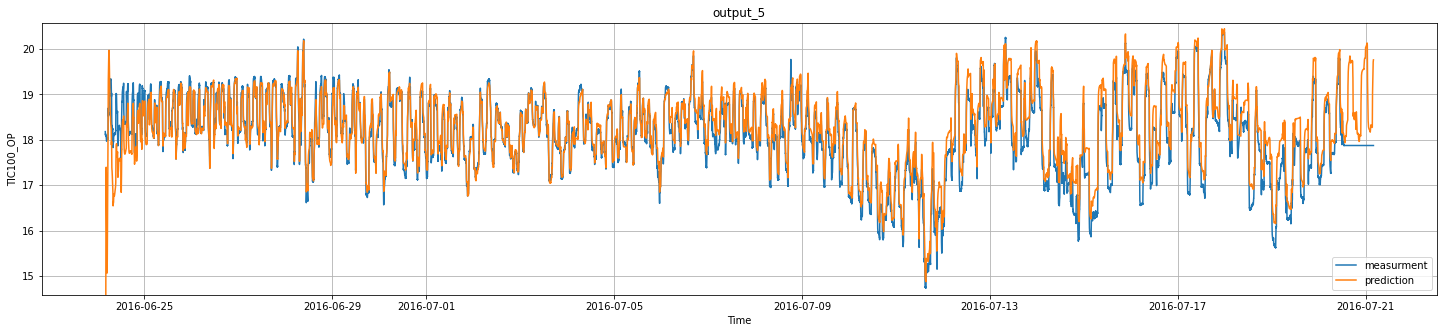

In [84]:
start_time = '2016-06-24 04:00:00'
end_time = '2016-07-21 04:00:00'
plot_comparison(step_test_data, inputs, outputs, start_time, end_time, plt_input=False)